# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
#bank-marketing-ml-classifiers
#Overall, the dataset represents results from 17 campaigns done over a period of 2.5 years (May'2008 to Nov'2010) corresponding to a total of 79354 contacts

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector

In [3]:
url = 'https://raw.githubusercontent.com/ashrivastav33/bank-marketing-ml-classifiers/refs/heads/main/data/bank-additional-full.csv'
bank_mkt_df = pd.read_csv(url, sep = ';')

In [4]:
bank_mkt_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
#Validating data is loaded correctly in the bank_mkt_df dataframe
bank_mkt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
##Exploring statistical details for bank_mkt_df dataframe
bank_mkt_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
# Looking for missing values
print(bank_mkt_df.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [8]:
# It looks like there is no null data but some of the categorical variables have 'unknown', for the
# purpose of modelling we'll keep these categories as 'unknown'

In [10]:
y = np.where(bank_mkt_df['y']=='yes',1,0)
X = bank_mkt_df.drop(['y','duration'], axis=1)

In [11]:
# Let's identify counts of unknown for each of the columns
X[X[['job','marital','education','default','housing','loan']] == 'unknown'].count() / X.count()

,0
age,0.000000
job,0.008012
marital,0.001942
education,0.042027
default,0.208726
housing,0.024036
loan,0.024036
contact,0.000000
month,0.000000
day_of_week,0.000000


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [13]:
# The business objective is to develop a predictive algorithm that identifies customers likely to
# accept the offer based on a number customer characteristics - this will allow to focus the
# limited resources of the organization / call center on customers most likely to accept the offer
# and have a benefit of reducing frustration (due to calls) from customers definitely won't

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [14]:
basic_transformer = ColumnTransformer([('scale', StandardScaler(),\
        make_column_selector(dtype_include=['int64', 'float64'])),\
        ('encode', OneHotEncoder(handle_unknown = 'ignore',drop='if_binary'),\
        make_column_selector(dtype_include=[object]))], sparse_threshold = 0)

In [15]:
X_transformed = pd.DataFrame(data = basic_transformer.fit_transform(X.iloc[:,:7]), columns = basic_transformer.get_feature_names_out())

#X_transformed = pd.DataFrame(data = basic_transformer.fit_transform(X), columns = basic_transformer.get_feature_names_out())

X_transformed.head()

,scale__age,encode__job_admin.,encode__job_blue-collar,encode__job_entrepreneur,encode__job_housemaid,encode__job_management,encode__job_retired,encode__job_self-employed,encode__job_services,encode__job_student,...,encode__education_unknown,encode__default_no,encode__default_unknown,encode__default_yes,encode__housing_no,encode__housing_unknown,encode__housing_yes,encode__loan_no,encode__loan_unknown,encode__loan_yes
0,1.533034,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.628993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.290186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.002309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.533034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [16]:
df_for_corr = pd.concat([X_transformed,pd.DataFrame(y)], axis = 1)
df_for_corr.rename(columns = {0:'y'}, inplace = True)

In [17]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = df_for_corr.corr().columns,
        y = df_for_corr.corr().index,
        z = np.array(df_for_corr.corr()
        )
    )
)
fig.update_layout(title = 'Correlation Matrix')

In [18]:
# Let's identify parameters with highest correlation with y
df_for_corr.corr().sort_values('y', ascending=False)['y'].head(5)

,y
y,1.000000
encode__default_no,0.099344
encode__job_student,0.093955
encode__job_retired,0.092221
encode__marital_single,0.054133


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = .2, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [21]:
# Baseline accuracy is equal to the frequency of the most common class (0)
1-y.sum()/len(y)

np.float64(0.8873458288821987)

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [22]:
import time
start_time = time.time()
lr = LogisticRegression(max_iter = 1000).fit(X_train,y_train)
lr_elapsed_time = time.time() - start_time
print(f'{lr_elapsed_time:.2f}s elapsed during training')

0.27s elapsed during training


### Problem 9: Score the Model

What is the accuracy of your model?

In [23]:
acc_sc = accuracy_score(y_test, lr.predict(X_test))
print(acc_sc)

0.8865015780529255


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [24]:
start_time=time.time()
knn = KNeighborsClassifier().fit(X_train,y_train)
knn_elapsed_time = time.time() - start_time
print(f'{knn_elapsed_time:.2f}s elapsed during training')

0.01s elapsed during training


In [25]:
start_time=time.time()
dt = DecisionTreeClassifier().fit(X_train,y_train)
dt_elapsed_time = time.time() - start_time
print(f'{dt_elapsed_time:.2f}s elapsed during training')

0.15s elapsed during training


In [26]:
start_time=time.time()
svm = SVC().fit(X_train,y_train)
svm_elapsed_time = time.time() - start_time
print(f'{svm_elapsed_time:.2f}s elapsed during training')

112.96s elapsed during training


In [27]:
results = pd.DataFrame({'model':['Logistic Regression',' KNN', 'Decision Tree', 'SVM'],\
                       'Train Time':[lr_elapsed_time,knn_elapsed_time,dt_elapsed_time,svm_elapsed_time],\
                       'Train Accuracy': [accuracy_score(y_train, lr.predict(X_train)), accuracy_score(y_train,knn.predict(X_train)),\
                        accuracy_score(y_train, dt.predict(X_train)),accuracy_score(y_train, svm.predict(X_train))],\
                       'Test Accuracy':[accuracy_score(y_test, lr.predict(X_test)), accuracy_score(y_test,knn.predict(X_test)),\
                        accuracy_score(y_test, dt.predict(X_test)),accuracy_score(y_test, svm.predict(X_test))]})

In [28]:
results.set_index('model')

,Train Time,Train Accuracy,Test Accuracy
model,,,
Logistic Regression,0.269165,0.887557,0.886502
KNN,0.006707,0.889712,0.872542
Decision Tree,0.146822,0.916601,0.862102
SVM,112.964658,0.888225,0.886744


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [29]:
lr_params = {'penalty': ['l1', 'l2'], 'C': np.linspace(0.01,100, 1000)}

In [30]:
lr_grid = RandomizedSearchCV(lr, param_distributions = lr_params, scoring = 'roc_auc', n_jobs = -1)

In [32]:
start_time=time.time()
lr_grid.fit(X_train,y_train)
lrg_elapsed_time = time.time() - start_time
print(f'{lrg_elapsed_time:.2f}s elapsed during training')

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

10.73s elapsed during training


In [34]:
knn_params = {'n_neighbors': range(1,len(y_test),2)}

In [35]:
knn_grid = RandomizedSearchCV(knn, param_distributions = knn_params, scoring = 'roc_auc', n_jobs = -1)

In [36]:
start_time=time.time()
knn_grid.fit(X_train,y_train)
kng_elapsed_time = time.time() - start_time
print(f'{kng_elapsed_time:.2f}s elapsed during training')

382.38s elapsed during training


In [38]:
dt_params = {'criterion': ['gini','entropy','log_loss'], 'max_depth':range(1,15,1), 'ccp_alpha' : range(0,1,100)}

In [39]:
dt_grid = RandomizedSearchCV(dt, param_distributions = dt_params, scoring = 'roc_auc', n_jobs = -1)

In [41]:
start_time=time.time()
dt_grid.fit(X_train,y_train)
dtg_elapsed_time = time.time() - start_time
print(f'{kng_elapsed_time:.2f}s elapsed during training')

382.38s elapsed during training


In [43]:
grid_summary = pd.DataFrame({'model':['Logistic Regression','KNN','Decision Tree'],\
        'run time': [lrg_elapsed_time, kng_elapsed_time, dtg_elapsed_time],\
        'auc score': [lr_grid.best_score_, knn_grid.best_score_, dt_grid.best_score_]})

In [46]:
grid_summary.set_index('model')

,run time,auc score
model,,
Logistic Regression,10.727889,0.647483
KNN,382.379547,0.657373
Decision Tree,15.513813,0.648930


In [47]:
lrfpr, lrtpr, lrthresholds = roc_curve(y_test, lr_grid.best_estimator_.predict_proba(X_test)[:,1])
knnfpr, knntpr, knnthresholds = roc_curve(y_test, knn_grid.best_estimator_.predict_proba(X_test)[:,1])
dtfpr, dttpr, dtthresholds = roc_curve(y_test, dt_grid.best_estimator_.predict(X_test))

In [49]:
import plotly.express as px

fig = px.area(
    x=knnfpr, y=knntpr,
    title=f'ROC Curve for KNN (best AUC) classifier',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [50]:
#Let's say we can only cover 50% of the population. Given the imbalanced nature of classes we'll ned to
#adjust the threshold

optimal_idx = np.argmax(knntpr - knnfpr)
optimal_threshold = knnthresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.11507293354943274


In [57]:
# new predictions w/ adjusted threshold
knn_y_test_adj = np.where(knn_grid.best_estimator_.predict_proba(X_test)[:,1]>knnthresholds[optimal_idx],\
                          1,0)

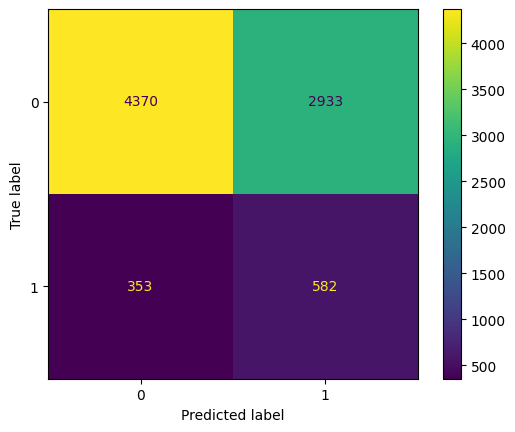

In [53]:
# Using the adjusted threshold, we get the following confusion matrix
cm = confusion_matrix(y_test, knn_y_test_adj)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()